In [3]:
from keras.models import load_model
from keras.layers import Dense
from keras.models import Sequential
from keras.models import Model
from sklearn.externals import joblib
import pandas as pd
import numpy as np

In [5]:
stdsc = joblib.load('stdsc_python.m')
df = pd.read_csv('data_python.csv')
T2 = df['Y0']
T_new = []
for i in range(1600):
    tmp = [0] * 9
    tmp.extend(T2[i * 146: (i + 1)* 146])
    for j in range(len(tmp) - 10):
        T_new.append(tmp[j: j + 10])
T_new = np.array(T_new)
train_data = np.load('python_train_data_gru_145.csv.npy')
target = np.load('python_train_target_gru_145.csv.npy')
T = target
P = train_data
P = stdsc.transform(P)
P_T = T_new
train_num = int(P.shape[0] * 0.8)
test_num = int(P.shape[0] * 0.2)
P_Train = P[:730, :]
T_Train = T[:730, :]
P_Test = P[train_num:, :]
T_Test = T[train_num:, :]
P_Train = P_Train.reshape(730,1,60)
P_Test = P_Test.reshape(test_num,1,60)
T_new_Train = P_T[:730, :]
T_new_Test = P_T[train_num:, :]
T_new_Train = T_new_Train.reshape(730,1,10)
T_new_Test = T_new_Test.reshape(test_num,1,10)

In [76]:
base_model = load_model('new_encoder_decoder_model_dynamic.h5')

In [77]:
x = Dense(16, activation='tanh', name='transfer_dense_1')(base_model.layers[-3].output)
x = Dense(8, activation='relu', name='transfer_dense_2')(x)
output = Dense(1, name='transfer_pred')(x)

In [78]:
base_model.layers.pop()

In [79]:
for layer in base_model.layers:
    layer.trainable = False

In [80]:
model = Model(inputs=base_model.inputs, outputs=output)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1, 60)        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1, 10)        0                                            
__________________________________________________________________________________________________
gru_4 (GRU)                     (None, 1, 16)        3696        input_3[0][0]                    
__________________________________________________________________________________________________
gru_6 (GRU)                     (None, 1, 8)         456         input_4[0][0]                    
__________________________________________________________________________________________________
gru_5 (GRU

In [81]:
T_Train = T_Train.reshape(730,1,1)
T_Test = T_Test.reshape(test_num,1,1)
model.compile(loss='mse', optimizer='adam')
history = model.fit([P_Train, T_new_Train], T_Train, batch_size=146, epochs=100,
                    validation_data=([P_Test,T_new_Test], T_Test))

Train on 730 samples, validate on 46400 samples
Epoch 1/100
730/730 [==============================] - 4s 5ms/step - loss: 2.0310e-04 - val_loss: 1.6289e-04
Epoch 2/100
730/730 [==============================] - 1s 990us/step - loss: 1.2523e-04 - val_loss: 1.1490e-04
Epoch 3/100
730/730 [==============================] - 1s 988us/step - loss: 8.4690e-05 - val_loss: 8.1583e-05
Epoch 4/100
730/730 [==============================] - 1s 971us/step - loss: 5.9681e-05 - val_loss: 6.5498e-05
Epoch 5/100
730/730 [==============================] - 1s 1ms/step - loss: 4.4101e-05 - val_loss: 4.8089e-05
Epoch 6/100
730/730 [==============================] - 1s 978us/step - loss: 3.5722e-05 - val_loss: 3.9812e-05
Epoch 7/100
730/730 [==============================] - 1s 1ms/step - loss: 3.0547e-05 - val_loss: 3.5411e-05
Epoch 8/100
730/730 [==============================] - 1s 994us/step - loss: 2.7326e-05 - val_loss: 3.2499e-05
Epoch 9/100
730/730 [==============================] - 1s 1ms/step - l

730/730 [==============================] - 1s 933us/step - loss: 3.1309e-06 - val_loss: 6.6700e-06
Epoch 75/100
730/730 [==============================] - 1s 932us/step - loss: 3.2293e-06 - val_loss: 6.2668e-06
Epoch 76/100
730/730 [==============================] - 1s 975us/step - loss: 3.3336e-06 - val_loss: 6.3494e-06
Epoch 77/100
730/730 [==============================] - 1s 952us/step - loss: 3.3356e-06 - val_loss: 6.8817e-06
Epoch 78/100
730/730 [==============================] - 1s 962us/step - loss: 3.4338e-06 - val_loss: 6.3308e-06
Epoch 79/100
730/730 [==============================] - 1s 898us/step - loss: 2.9902e-06 - val_loss: 6.1421e-06
Epoch 80/100
730/730 [==============================] - 1s 1ms/step - loss: 2.9867e-06 - val_loss: 6.6248e-06
Epoch 81/100
730/730 [==============================] - 1s 951us/step - loss: 3.0913e-06 - val_loss: 5.7740e-06
Epoch 82/100
730/730 [==============================] - 1s 904us/step - loss: 2.7416e-06 - val_loss: 5.7799e-06
Epoch 8

In [82]:
pred = model.predict([P_Test, T_new_Test])
pred.shape

(46400, 1, 1)

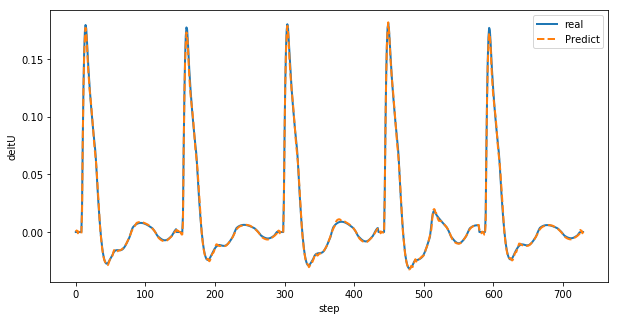

In [83]:
import matplotlib.pyplot as plt
pred1 = [pred[i,0,0] for i in range(730)]
real = [T_Test[i,0,0] for i in range(730)]
plt.figure(figsize=(10,5))
plt.plot(real, linewidth=2, label='real')
plt.plot(pred1, linewidth=2, label='Predict', linestyle='--')
plt.xlabel('step')
plt.ylabel('deltU')
plt.legend()
plt.show()

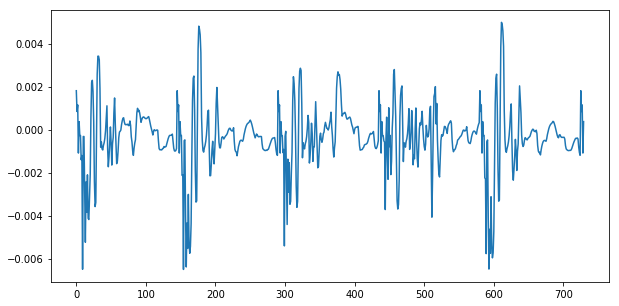

In [84]:
plt.figure(figsize=(10,5))
plt.plot([pred1[i] - real[i] for i in range(730)])
plt.show()